In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 50 # node size
num_data = 1000 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 84.4678
0 -> 16 -> 21 -> 42 -> 3 -> 5 -> 8 -> 13 -> 7 -> 18 -> 36 -> 2 -> 27 -> 47 -> 11 -> 20 -> 23 -> 22 -> 9 -> 25 -> 46 -> 19 -> 6 -> 14 -> 24 -> 44 -> 26 -> 43 -> 45 -> 39 -> 29 -> 48 -> 40 -> 1 -> 12 -> 41 -> 30 -> 10 -> 15 -> 17 -> 37 -> 32 -> 34 -> 49 -> 33 -> 35 -> 4 -> 31 -> 28 -> 38 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)

In [5]:
# get training and test data set
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.88it/s]


Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.48it/s]


In [6]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train) # with binding constr

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:32<00:00,  4.70it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-1, num_epochs+1)
    plt.ylim(0, 0.8)
    plt.xticks(range(0, num_epochs+1, 5), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
import time
from earlystop import earlyStopper

def train(reg, loss_func, lr, num_epochs, log_step):
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    # init log
    loss_log = []
    regret_log_trn = [pyepo.metric.regret(reg, optmodel, loader_train_cost)]
    regret_log_val = [pyepo.metric.regret(reg, optmodel, loader_test)]
    # running time
    elapsed = 0
    for epoch in range(num_epochs):
        tick = time.time()
        for data in loader_train:
            x, _, _, t_ctr = data
            # forward pass
            cp = reg(x)
            loss = loss_func(cp, t_ctr)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
        # record time
        tock = time.time()
        elapsed += tock - tick
        if (epoch+1) % log_step == 1:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_test)
            regret_log_val.append(regret_val)
            print("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                  format(epoch, loss.item(), regret_trn*100, regret_val*100))
            # early stop
            if stopper.stop(regret_val):
                print("Early Stop!")
                break
    print("Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, regret_log_trn, regret_log_val

### 2-Stage 

In [11]:
# init model
reg = LinearRegression()

In [12]:
from torch import nn
# init loss
mse = nn.MSELoss()

In [13]:
lr = 5e-2
num_epochs = 40
log_step = 2
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
# set stopper
stopper = earlyStopper(patience=3)
# init log
loss_log = []
regret_log_trn = [pyepo.metric.regret(reg, optmodel, loader_train_cost)]
regret_log_val = [pyepo.metric.regret(reg, optmodel, loader_test)]
# running time
elapsed = 0
for epoch in range(num_epochs):
    tick = time.time()
    for data in loader_train:
        x, c, _, _ = data
        # forward pass
        cp = reg(x)
        loss = mse(cp, c)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    # record time
    tock = time.time()
    elapsed += tock - tick
    if (epoch+1) % log_step == 1:
        # regret
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_test)
        regret_log_val.append(regret_val)
        print("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
              format(epoch, loss.item(), regret_trn*100, regret_val*100))
        # early stop
        if stopper.stop(regret_val):
            print("Early Stop!")
            break
print("Elapsed Time: {:.2f} Sec".format(elapsed))

Epoch   0, Loss:  46.6698, Train Regret:  45.3263%, Val Regret:  45.8836%
Epoch   2, Loss:  21.2285, Train Regret:  42.0179%, Val Regret:  42.6064%
Epoch   4, Loss:   6.9984, Train Regret:  38.3963%, Val Regret:  38.8934%
Epoch   6, Loss:   7.0828, Train Regret:  33.7656%, Val Regret:  34.2656%
Epoch   8, Loss:   7.8603, Train Regret:  30.6773%, Val Regret:  31.4370%
Epoch  10, Loss:   8.9626, Train Regret:  29.5222%, Val Regret:  30.0120%
Epoch  12, Loss:   7.6088, Train Regret:  28.9312%, Val Regret:  29.5727%
Epoch  14, Loss:   7.5703, Train Regret:  28.6357%, Val Regret:  29.2368%
Epoch  16, Loss:   6.8681, Train Regret:  28.7355%, Val Regret:  29.1446%
Epoch  18, Loss:  10.0527, Train Regret:  28.6901%, Val Regret:  29.1633%
Epoch  20, Loss:  10.7474, Train Regret:  28.6249%, Val Regret:  29.2142%
Epoch  22, Loss:   6.9677, Train Regret:  28.6699%, Val Regret:  29.1609%
Early Stop!
Elapsed Time: 208.66 Sec


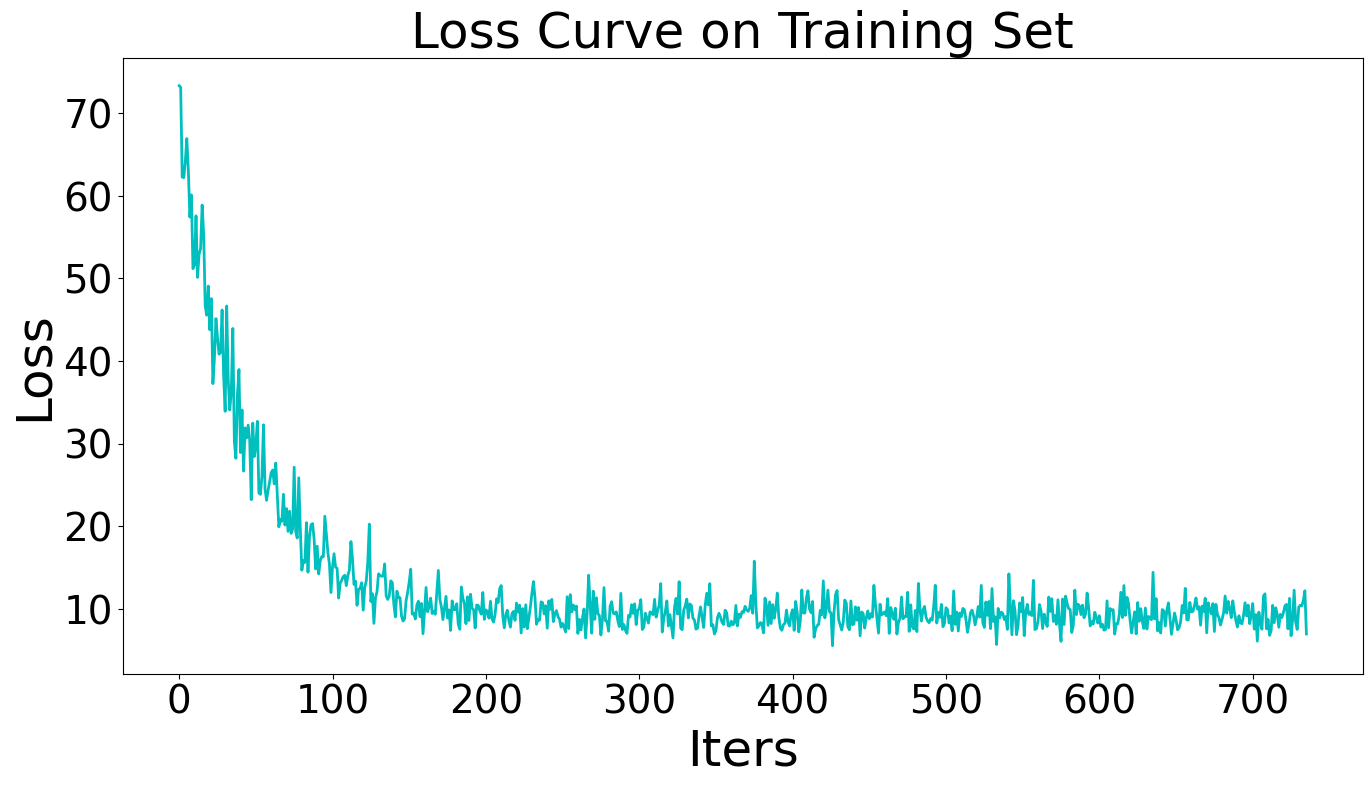

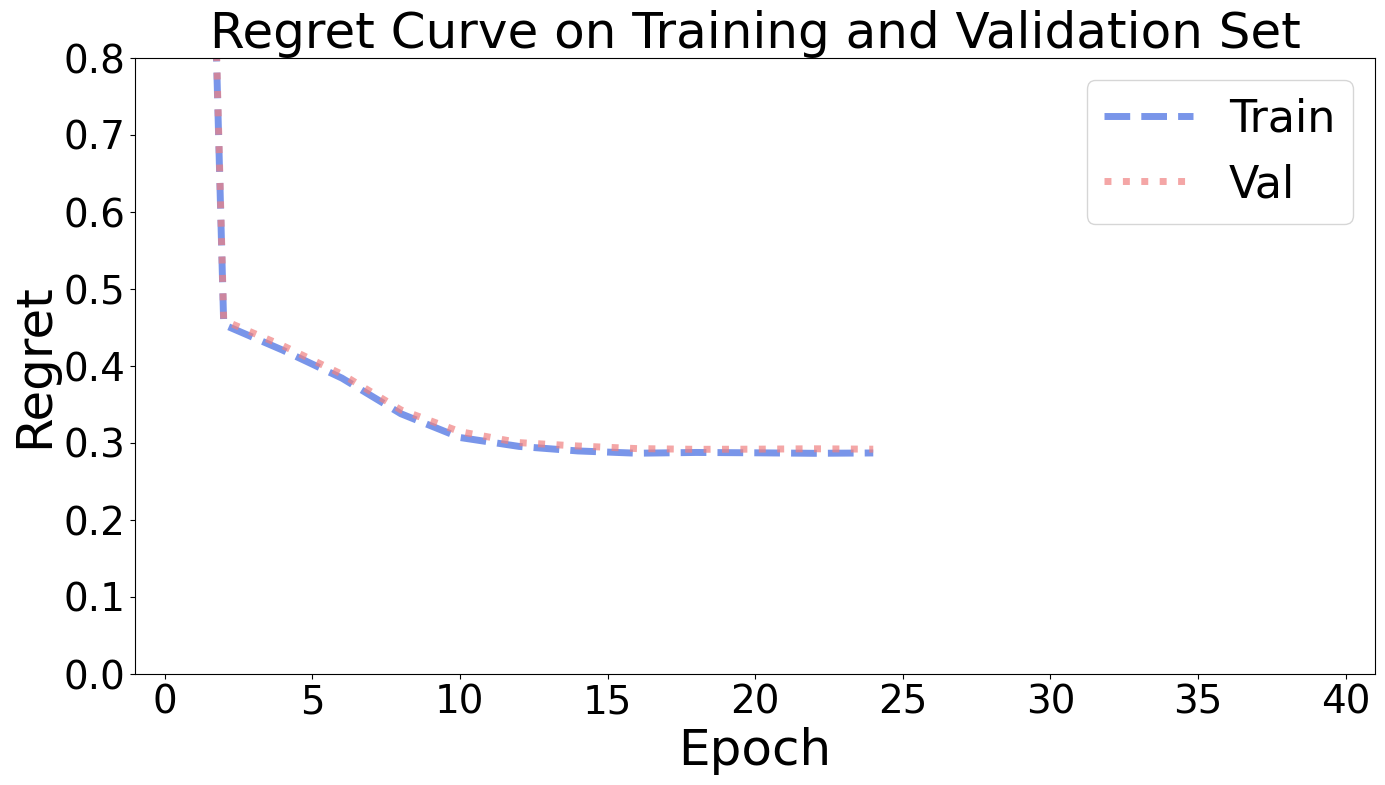

In [14]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### NNLS Method 

In [15]:
# init model
reg = LinearRegression()

In [16]:
from func import nnlsConeAlignedCosine
# init loss
ca_cos = nnlsConeAlignedCosine(optmodel, processes=8)

Num of cores: 8


In [17]:
lr = 5e-2
num_epochs = 40
log_step = 2
loss_log, regret_log_trn, regret_log_val = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.9987, Train Regret:  23.3948%, Val Regret:  27.9658%
Epoch   2, Loss:  -0.9997, Train Regret:  13.7135%, Val Regret:  17.1776%
Epoch   4, Loss:  -0.9944, Train Regret:  12.7581%, Val Regret:  15.8061%
Epoch   6, Loss:  -0.9998, Train Regret:  11.8758%, Val Regret:  15.2873%
Epoch   8, Loss:  -0.9998, Train Regret:  10.6271%, Val Regret:  14.1484%
Epoch  10, Loss:  -0.9999, Train Regret:  10.8381%, Val Regret:  14.7959%
Epoch  12, Loss:  -0.9999, Train Regret:  12.0350%, Val Regret:  15.7124%
Epoch  14, Loss:  -0.9999, Train Regret:  11.2161%, Val Regret:  15.1779%
Early Stop!
Elapsed Time: 13894.53 Sec


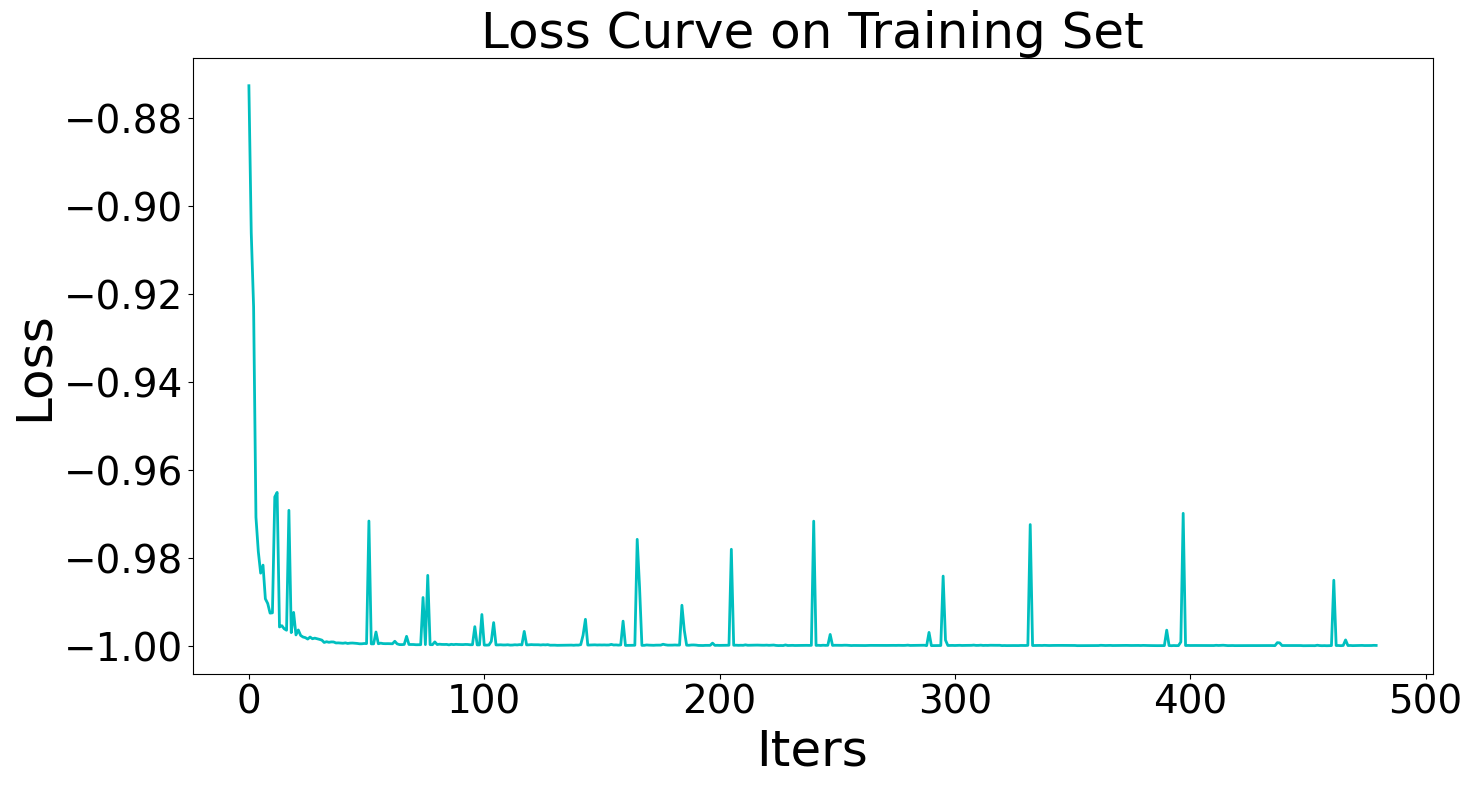

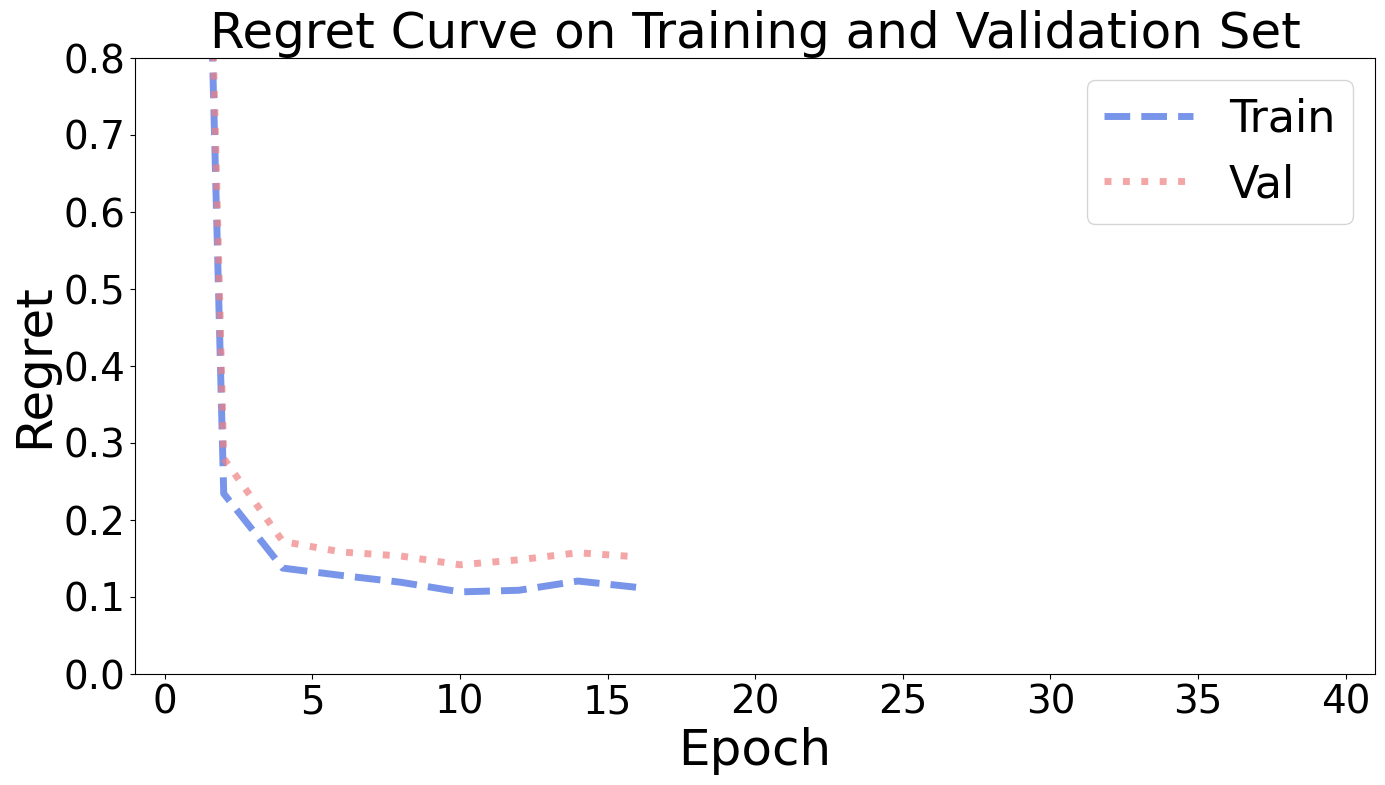

In [18]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)